In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
gender_df = pd.read_csv("../input/titanic/gender_submission.csv")
test_df = pd.read_csv("../input/titanic/test.csv")
train_df = pd.read_csv("../input/titanic/train.csv")

In [3]:
gender_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [4]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Insights,

`‘Survived’` is the target variable, which we will predict once our preprocessing of our data is done. So, we retain that column.
Only the columns such as `‘Age’`, `‘Cabin’` and `‘Embarked’` has missing values.
`‘PassengerId’`, `‘Name’` and `‘Ticket’` doesn’t add much value in predicting the target variable.
`‘ParCh’(Parent/Children)` and `‘SibSp’(Siblings/Spouse)` details are related to family, so we can derive a new column named `‘Size of the family’`
`‘Sex’`, `‘Cabin’` and `‘Embarked’` are the categorical data that needs to be encoded to numerical values.

# Data Wrangling
* Train Dataset

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* As you can see, there are several NaN that will definitely need cleaning with the `Cabin` feature having the most

### Data cleaning

In [7]:
# Let us get the clear picture
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

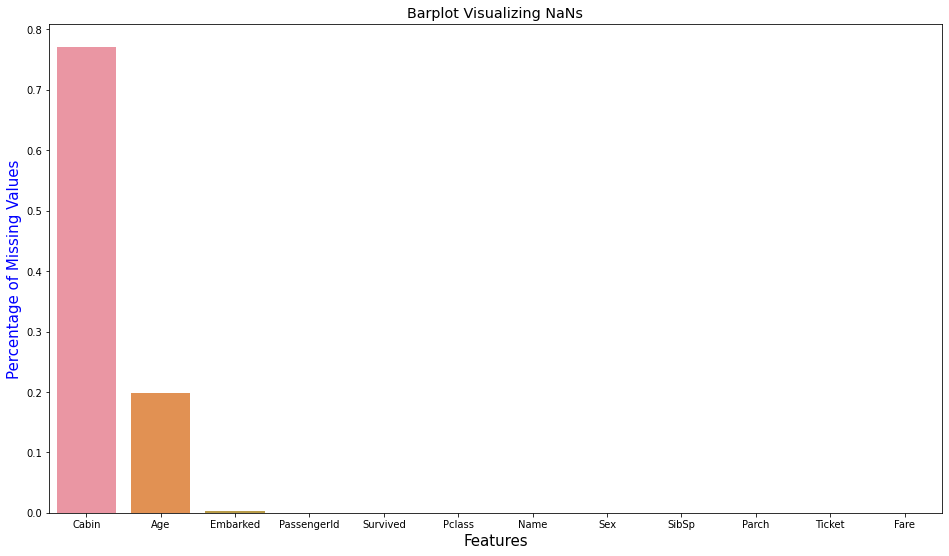

In [8]:
# Plotting NaNs
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending = False)
missing = pd.concat([total, percent], axis = 1, keys = ["total", "percent"])
_,ax = plt.subplots(figsize =(16,9))
plt.style.use("ggplot")
sns.barplot(x = missing.index, y = missing["percent"])
plt.xlabel("Features", fontsize = 15)
plt.ylabel("Percentage of Missing Values", fontsize = 15, c = "blue")
plt.title("Barplot Visualizing NaNs"); # Introduce semi-colon to suppress the unnecessary text

* `Embarked`

In [9]:
train_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

`‘Embarked’`: Only two rows are missing the values for Embarked column.
Embarked takes categorical values such as C = Cherbourg; Q = Queenstown; S = Southampton, here we can simply impute the missing values with most commonly occurred value, which is ‘S’ in this case.

In [10]:
train_df["Embarked"] = train_df["Embarked"].fillna("S")
train_df["Embarked"].isnull().sum().any()

False

* `Cabin`

In [11]:
train_df.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [12]:
train_df["Cabin"] = train_df["Cabin"].fillna("G6")
train_df.Cabin.isnull().sum().any()

False

* `Age`: We are going the impute the missing values in the ‘Age’ column by taking the mean value in each group. Taking the mean value of the whole column can make the data inconsistent because there are several ranges in age. Hence we will need to feature engineer different groups

In [13]:
# Using expression pattern to extract the titles of the passengers
train_df["Title"] = train_df.Name.str.extract(" ([A-Za-z]+)\.", expand = False)

train_df["Title"] = train_df["Title"].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 
                                                  'Nobles'                                             
                                                 )
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
train_df['Title'] = train_df['Title'].replace('Mlle', 'Mr')

In [14]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G6,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G6,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,G6,S,Mr


In [15]:
means = train_df.groupby('Title')['Age'].mean()

title_list = ['Master','Miss','Mr','Mrs','Nobles']
def age_missing_replace(means, dframe, title_list):
    for title in title_list:
        temp = dframe['Title'] == title 
        dframe.loc[temp, 'Age'] = dframe.loc[temp, 'Age'].fillna(means[title]) 
        
age_missing_replace(means, train_df, title_list)

### Feature Engineering
* Decks

In [16]:
def assignDeckValue(CabinCode):
    if pd.isnull(CabinCode):
        category = "Berth"
    else:
        category = CabinCode[0]
    return category
Deck = np.array([assignDeckValue(cabin) for cabin in train_df["Cabin"].values])
train_df = train_df.assign(Deck = Deck)

* Family Size

`‘ParCh’` and `‘SibSp’` are the details related to family size, so let’s derive a new column named ‘Size of the Family’.

In [17]:
train_df["FamSize"] = train_df.Parch + train_df.SibSp + 1

In [18]:
# We will drop `Name`, `Ticket` and `Cabin` since they will not contribute much
train_df = train_df.drop(columns=["Name", "Ticket", "Cabin"])

In [19]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamSize
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,G,2
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,C,2
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,G,1
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,C,2
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,G,1


In [20]:
train_df["Age"] = train_df["Age"].astype("int")

In [21]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamSize
0,1,0,3,male,22,1,0,7.2500,S,Mr,G,2
1,2,1,1,female,38,1,0,71.2833,C,Mrs,C,2
2,3,1,3,female,26,0,0,7.9250,S,Miss,G,1
3,4,1,1,female,35,1,0,53.1000,S,Mrs,C,2
4,5,0,3,male,35,0,0,8.0500,S,Mr,G,1


* We will do the same for the test dataset

In [22]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [23]:
test_df.shape

(418, 11)

In [24]:
test_df["FamSize"] = test_df.Parch + test_df.SibSp + 1

In [25]:
# Using expression pattern to extract the titles of the passengers
test_df["Title"] = test_df.Name.str.extract(" ([A-Za-z]+)\.", expand = False)

test_df["Title"] = test_df["Title"].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 
                                                  'Nobles'                                             
                                                 )
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')
test_df['Title'] = test_df['Title'].replace('Mlle', 'Mr')

In [26]:
means = test_df.groupby('Title')['Age'].mean()

title_list = ['Master','Miss','Mr','Mrs','Nobles']
def age_missing_replace(means, dframe, title_list):
    for title in title_list:
        temp = dframe['Title'] == title 
        dframe.loc[temp, 'Age'] = dframe.loc[temp, 'Age'].fillna(means[title]) 
        
age_missing_replace(means, test_df, title_list)

In [27]:
def assignDeckValue(CabinCode):
    if pd.isnull(CabinCode):
        category = "Berth"
    else:
        category = CabinCode[0]
    return category
Deck = np.array([assignDeckValue(cabin) for cabin in test_df["Cabin"].values])
test_df = test_df.assign(Deck = Deck)

In [28]:
test_df = test_df.drop(columns=["Name", "Ticket", "Cabin"])

In [29]:
test_df["Age"] = test_df["Age"].astype("int")

In [30]:
train_df["Embarked"] = train_df["Embarked"].fillna("S")

In [31]:
test_df.isnull().any()

PassengerId    False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Fare            True
Embarked       False
FamSize        False
Title          False
Deck           False
dtype: bool

In [32]:
test_df.Title = test_df.Title.str.replace("Dona", "Mr")

In [33]:
test_df.Fare.value_counts()

7.7500     21
26.0000    19
13.0000    17
8.0500     17
7.8958     11
           ..
7.8208      1
8.5167      1
78.8500     1
52.0000     1
22.3583     1
Name: Fare, Length: 169, dtype: int64

In [34]:
test_df.Fare = test_df.Fare.fillna(test_df.Fare.mean())

In [35]:
test_df["Title"] = test_df["Title"].fillna("Mr")

In [36]:
test_df.isnull().sum().any()

False

In [37]:
test_df.tail()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamSize,Title,Deck
413,1305,3,male,32,0,0,8.0500,S,1,Mr,Berth
414,1306,1,female,39,0,0,108.9000,C,1,Mr,C
415,1307,3,male,38,0,0,7.2500,S,1,Mr,Berth
416,1308,3,male,32,0,0,8.0500,S,1,Mr,Berth
417,1309,3,male,7,1,1,22.3583,C,3,Master,Berth


In [38]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamSize
0,1,0,3,male,22,1,0,7.2500,S,Mr,G,2
1,2,1,1,female,38,1,0,71.2833,C,Mrs,C,2
2,3,1,3,female,26,0,0,7.9250,S,Miss,G,1
3,4,1,1,female,35,1,0,53.1000,S,Mrs,C,2
4,5,0,3,male,35,0,0,8.0500,S,Mr,G,1


In [39]:
num_cols = ["Age", "Fare", "Parch", "SibSp"]
train_df[num_cols].describe()

,Age,Fare,Parch,SibSp
count,891.000000,891.000000,891.000000,891.000000
mean,29.641975,32.204208,0.381594,0.523008
std,13.297325,49.693429,0.806057,1.102743
min,0.000000,0.000000,0.000000,0.000000
25%,21.000000,7.910400,0.000000,0.000000
50%,30.000000,14.454200,0.000000,0.000000
75%,35.000000,31.000000,0.000000,1.000000
max,80.000000,512.329200,6.000000,8.000000


### Encoding

In [40]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_df['Deck'] = le.fit_transform(train_df['Deck'])

In [41]:
train_df.Title.value_counts()

Mr        519
Miss      183
Mrs       126
Master     40
Nobles     23
Name: Title, dtype: int64

In [42]:
train_df['Embarked'] = train_df['Embarked'].map({'C':0, 'Q':1, 'S':2})
train_df['Sex'] = train_df['Sex'].map({'male':0, 'female':1})
train_df['Title'] = train_df['Title'].map({'Master':0,'Miss':1,'Mr':2,'Mrs':3,'Nobles':4})

# Exploratory Data Analysis

In [43]:
corr = train_df[num_cols].corr()
corr

,Age,Fare,Parch,SibSp
Age,1.000000,0.092376,-0.195639,-0.268430
Fare,0.092376,1.000000,0.216225,0.159651
Parch,-0.195639,0.216225,1.000000,0.414838
SibSp,-0.268430,0.159651,0.414838,1.000000


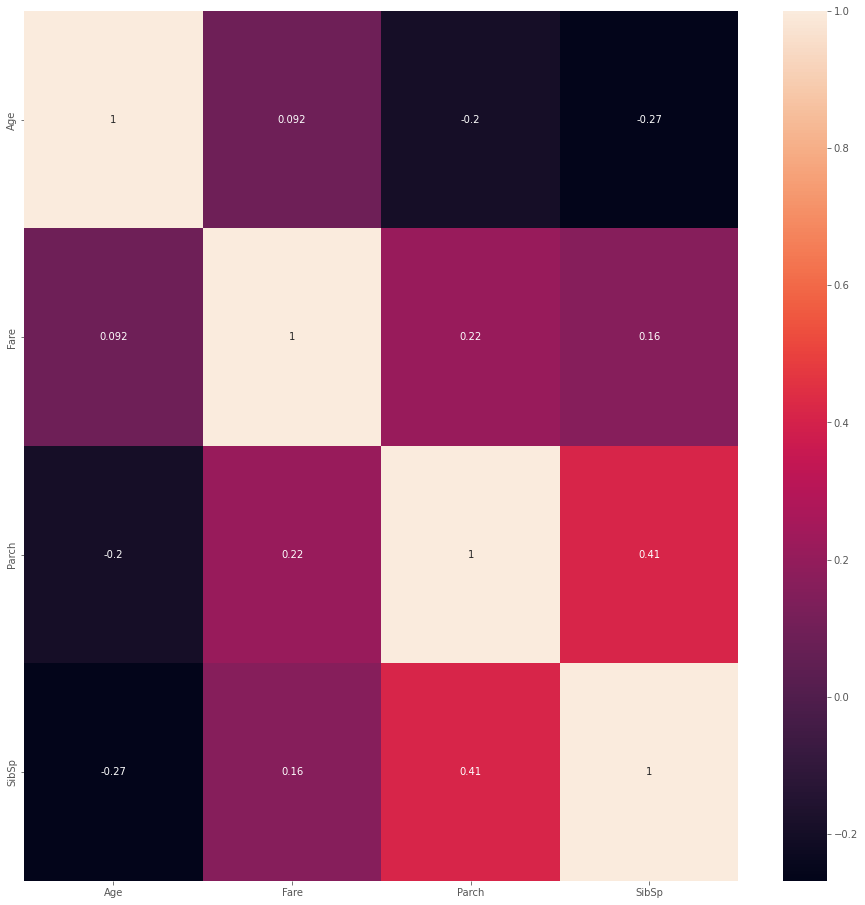

In [44]:
f, ax = plt.subplots(figsize = (16,16))
sns.heatmap(corr, annot=True);

* Fare vs Title

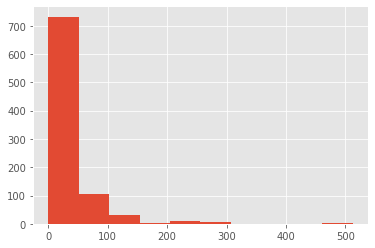

In [45]:
plt.hist(train_df["Fare"]);

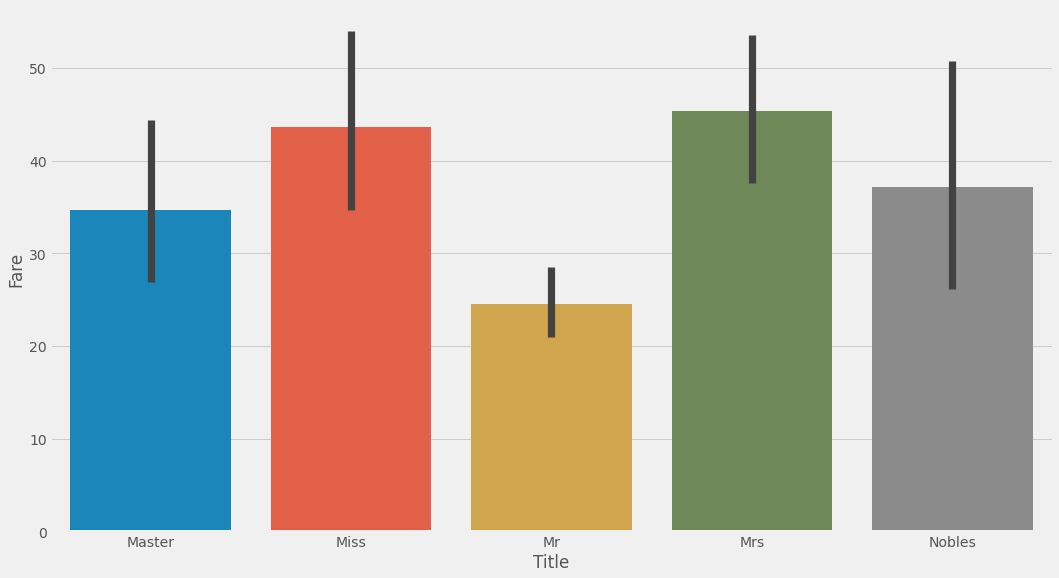

In [46]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(16,9))
sns.barplot(x = train_df.Title, y = train_df.Fare)
plt.xticks([0,1,2,3,4],['Master','Miss','Mr','Mrs','Nobles']);

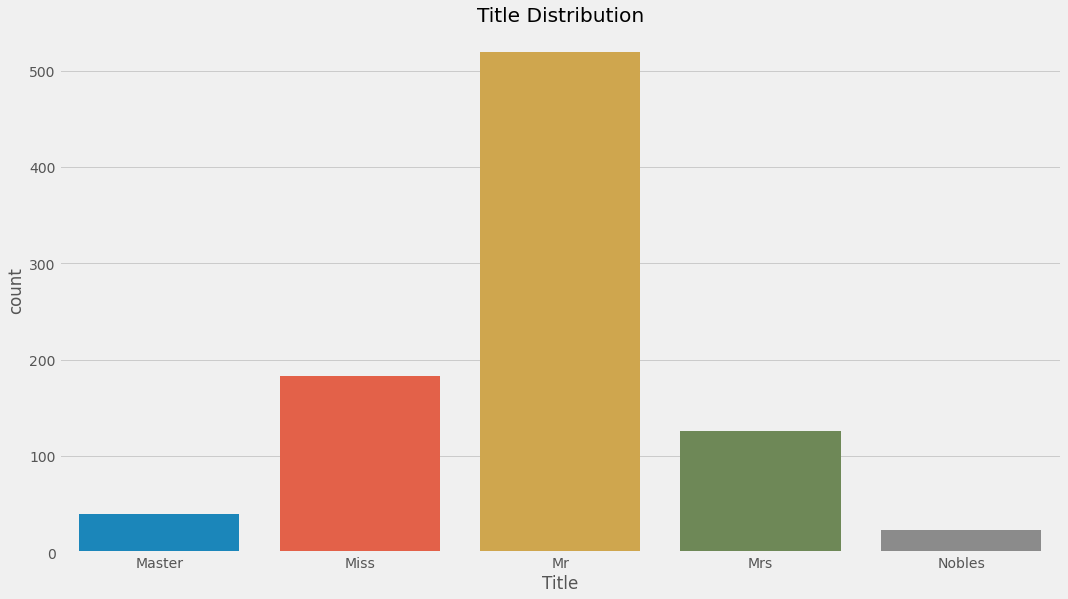

In [47]:
plt.figure(figsize=(16,9))
sns.countplot(train_df.Title)
plt.title("Title Distribution")
plt.xticks([0,1,2,3,4],['Master','Miss','Mr','Mrs','Nobles']);

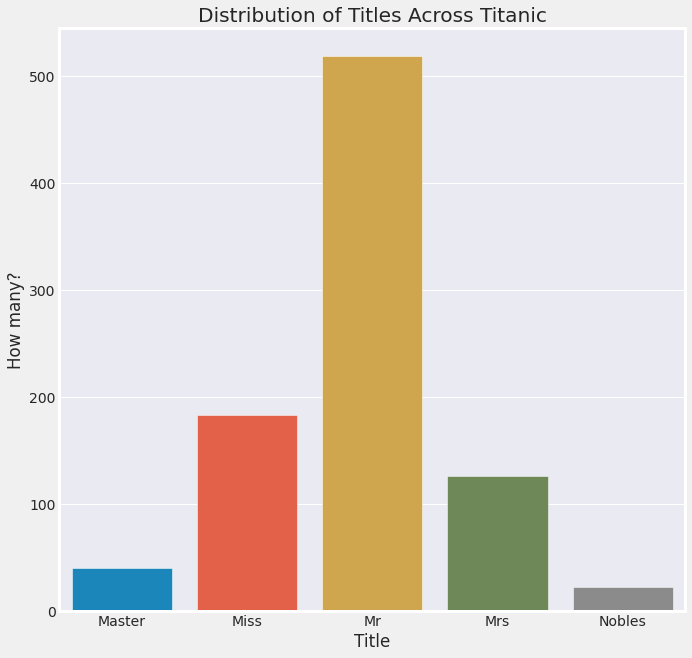

In [48]:
x = train_df["Title"].value_counts()
plt.figure(figsize=(10,10))
sns.set_style("darkgrid")   #set style to whitegrid
ax= sns.barplot(x.index,x.values)   #using bar for visualization
ax.set_xlabel("Title")
ax.set_ylabel("How many?")
ax.set_title("Distribution of Titles Across Titanic");
plt.xticks([0,1,2,3,4],['Master','Miss','Mr','Mrs','Nobles']);

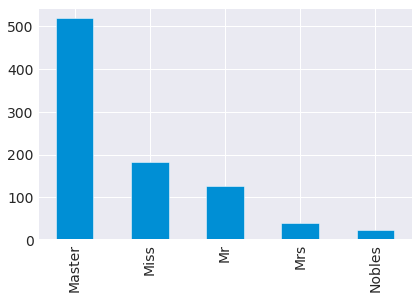

In [49]:
train_df.Title.value_counts().plot(kind="bar")
plt.xticks([0,1,2,3,4],['Master','Miss','Mr','Mrs','Nobles']);

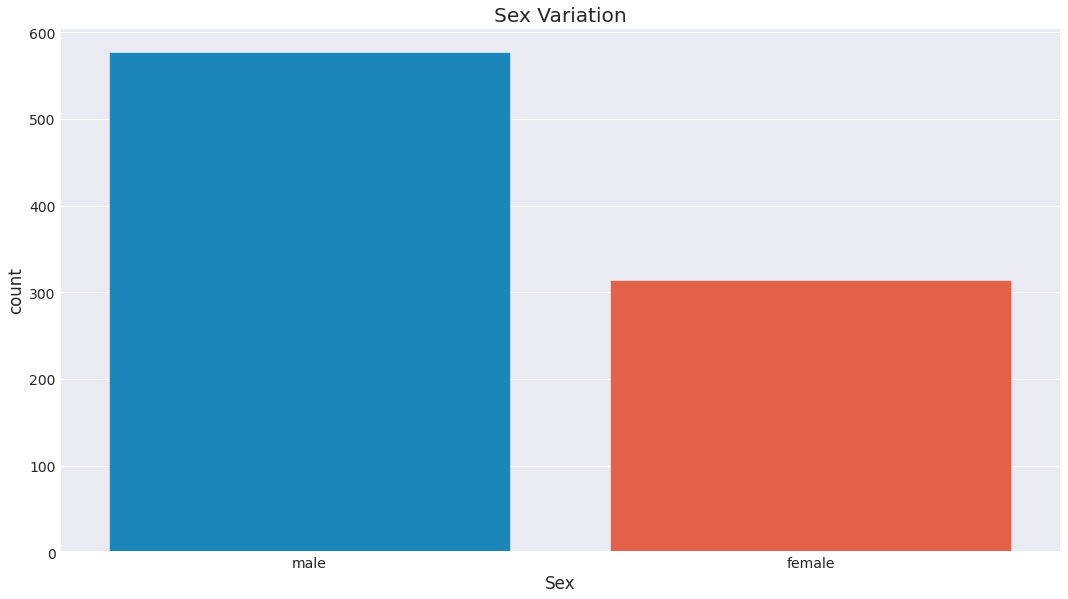

In [50]:
plt.figure(figsize=(16,9))
sns.countplot(train_df["Sex"])
plt.title("Sex Variation")
plt.xticks([0,1],['male', 'female']);

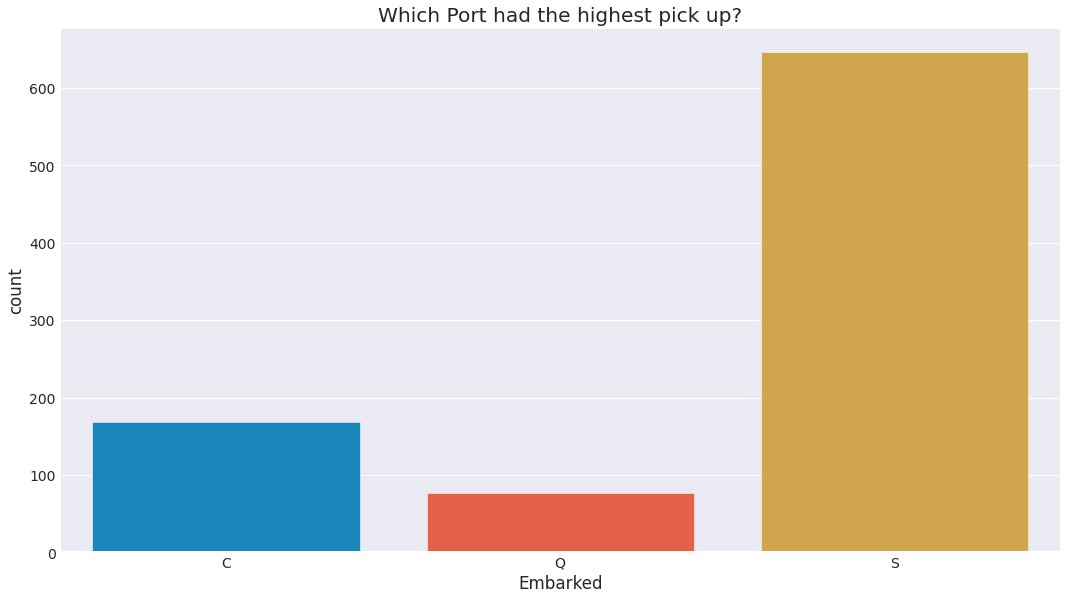

In [51]:
plt.figure(figsize=(16,9))
sns.countplot(train_df["Embarked"])
plt.title("Which Port had the highest pick up?")
plt.xticks([0,1,2],['C', 'Q', 'S']);

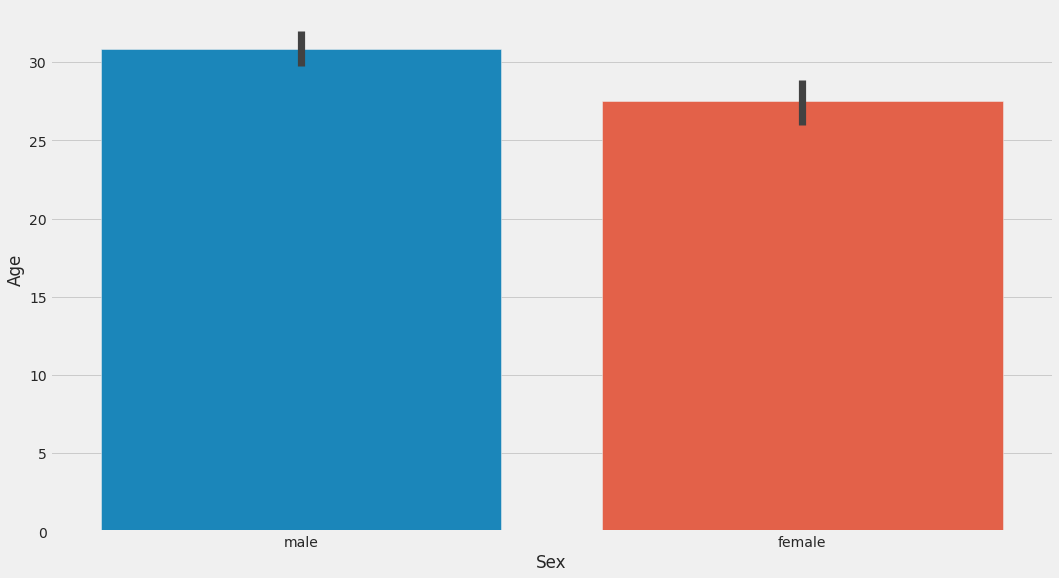

In [52]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(16,9))
sns.barplot(x = train_df.Sex, y = train_df.Age)
plt.xticks([0,1],['male', 'female']);

<AxesSubplot:>

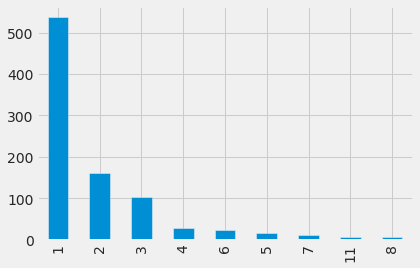

In [53]:
train_df.FamSize.value_counts().plot(kind="bar")

<Figure size 1152x648 with 0 Axes>

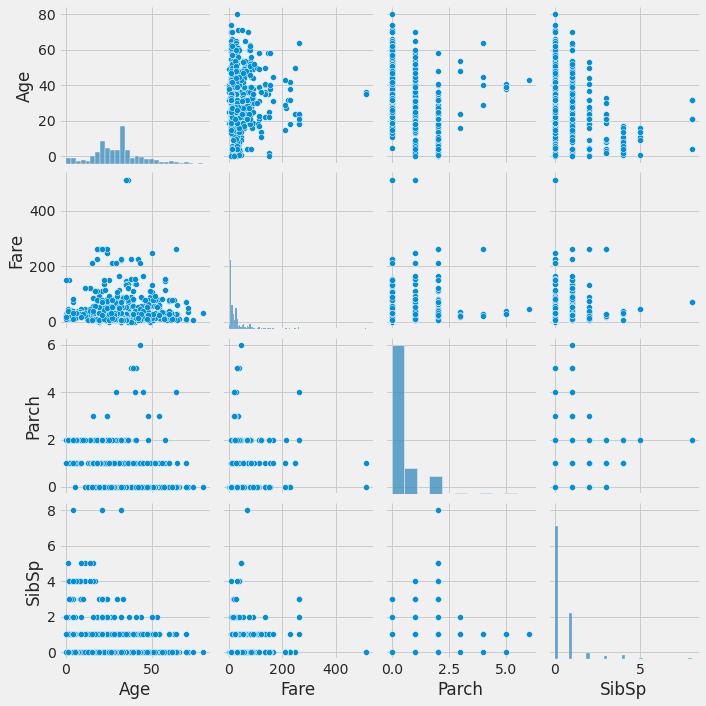

In [54]:
plt.figure(figsize = (16,9))
sns.pairplot(train_df[num_cols])

# Modelling

In [55]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamSize
0,1,0,3,0,22,1,0,7.2500,2,2,6,2
1,2,1,1,1,38,1,0,71.2833,0,3,2,2
2,3,1,3,1,26,0,0,7.9250,2,1,6,1
3,4,1,1,1,35,1,0,53.1000,2,3,2,2
4,5,0,3,0,35,0,0,8.0500,2,2,6,1


In [56]:
target = "Survived"
X = train_df.drop(columns = target)
y = train_df[target]

In [57]:
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 0)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       168
           1       0.77      0.69      0.73       100

    accuracy                           0.81       268
   macro avg       0.80      0.78      0.79       268
weighted avg       0.80      0.81      0.80       268

Auc: 0.8


In [58]:
%%time
from sklearn.model_selection import cross_validate

cv_result = cross_validate(model, X, y, cv=5)
cv_result

CPU times: user 143 ms, sys: 0 ns, total: 143 ms
Wall time: 144 ms


{'fit_time': array([0.02871513, 0.02579141, 0.02668881, 0.0260303 , 0.02484465]),
 'score_time': array([0.00150919, 0.00148296, 0.00140977, 0.00144029, 0.0014801 ]),
 'test_score': array([0.81005587, 0.80337079, 0.76966292, 0.75842697, 0.79213483])}

In [59]:
scores = cv_result["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.787 +/- 0.020


In [60]:
test_df['Embarked'] = test_df['Embarked'].map({'C':0, 'Q':1, 'S':2})
test_df['Sex'] = test_df['Sex'].map({'male':0, 'female':1})
test_df['Title'] = test_df['Title'].map({'Master':0,'Miss':1,'Mr':2,'Mrs':3,'Nobles':4})

In [61]:
le = preprocessing.LabelEncoder()
test_df['Deck'] = le.fit_transform(test_df['Deck'])

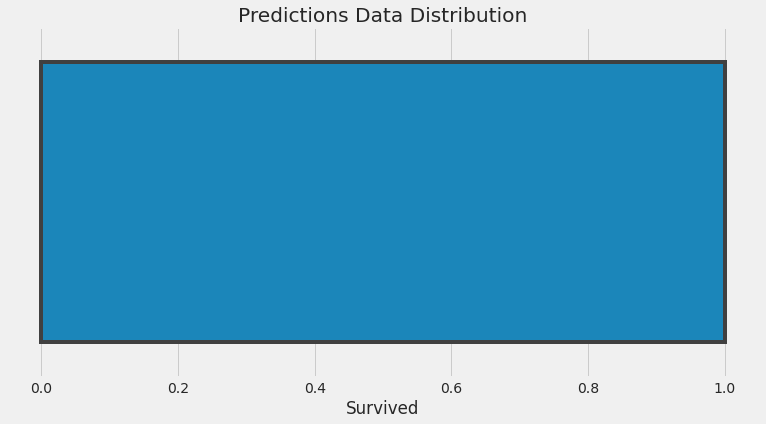

In [62]:
# Make prediction on the test set
predictions = model.predict(test_df)

# # Create a submission file
sub_file = gender_df.copy()
sub_file.Survived = predictions

# Check the distribution of your predictions
plt.figure(figsize=(12, 6))
sns.boxplot(sub_file.Survived)
plt.title('Predictions Data Distribution');

In [63]:
# Preview the sub_file
sub_file.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# Trying other different algorithms
* ## Random Forests

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print(classification_report(y_test, y_pred))
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       168
           1       0.79      0.73      0.76       100

    accuracy                           0.83       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.83      0.83      0.83       268

Auc: 0.82


In [65]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8283582089552238


* ## Dummy Classifier

In [66]:
from sklearn.dummy import DummyClassifier

class_to_predict = 1
clf = DummyClassifier(strategy = "constant", constant = class_to_predict)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy of a model predicting only high revenue: {score:.3f}")

Accuracy of a model predicting only high revenue: 0.373


In [67]:
class_to_predict = 0
clf = DummyClassifier(strategy = "constant", constant = class_to_predict)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy of a model predicting only high revenue: {score:.3f}")

Accuracy of a model predicting only high revenue: 0.627


* So the LogisticRegression accuracy (roughly 82%) seems better than the DummyClassifier accuracy (roughly 37%/63%). In a way it is a bit reassuring, using a machine learning model gives you a better performance than always predicting the majority class